In [1]:
import numpy as np
from tqdm import tqdm
import math

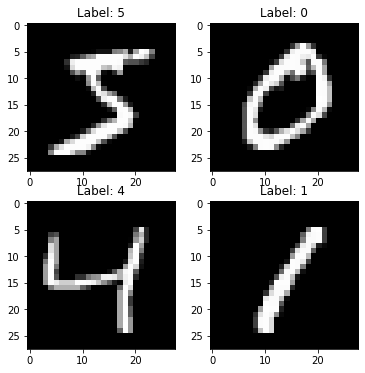

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [224]:
import math
np.random.seed(0)
def xavier_init(x_in, x_out):
    scale = 1/max(1., (x_in+x_out)/2.)
    weights = np.sqrt(scale)*np.random.randn(x_in,x_out)
    return weights

In [301]:
#784 -> 256 -> 64 -> 64 -> 10

In [394]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    if np.isinf(xentropy).any():
        return 10*np.ones((xentropy.shape[0],))
    else:
        return xentropy
    
    

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [409]:
class Custom_NN:
    
    def __init__(self, batch, lr, decay, epochs, mean = 0, var = 1, alpha = 0.01):
        
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        self.decay = decay
        self.running_mean = mean
        self.running_var = var
        self.alpha = alpha
        
    def init_weights(self, X):
        
        self.w1 = xavier_init(X.shape[1],512)
        self.w2 = xavier_init(self.w1.shape[1],256)
        self.w3 = xavier_init(self.w2.shape[1],64)
        self.w4  = xavier_init(self.w3.shape[1], 10)
        
        self.b1 = xavier_init(self.w1.shape[1], 1)
        self.b2 = xavier_init(self.w2.shape[1],1)
        self.b3 = xavier_init(self.w3.shape[1],1)
        self.b4 = xavier_init(self.w4.shape[1],1)
        
        self.bn_gamma = 1
        self.bn_beta = 0
        self.bn_eps = 1e-5
        
    def forward(self, X, ftype = 'Train'):
        
        if ftype == 'Train':
            
            self.z1 = X.dot(self.w1)+self.b1.T 
            self.y1 = self.relu(self.z1)
            self.dropout_y = self.dropout(self.y1)
        
            self.z2 = self.dropout_y.dot(self.w2)+self.b2.T
            self.y2 = self.relu(self.z2)
        
            self.z3 = self.y2.dot(self.w3)+self.b3.T
            #self.batch_y = self.batchnorm_forward(self.z3, btype = 'Train')
            self.y3 = self.elu(self.z3)
        
            self.z4 = self.y3.dot(self.w4) + self.b4.T
            
        else:
            
            self.z1 = X.dot(self.w1)+self.b1.T 
            self.y1 = self.relu(self.z1)
            #self.dropout_y = self.dropout(self.y1)
        
            self.z2 = self.y1.dot(self.w2)+self.b2.T
            self.y2 = self.relu(self.z2)
        
            self.z3 = self.y2.dot(self.w3)+self.b3.T
            #self.batch_y = self.batchnorm_forward(self.z3, btype = 'Test')
            self.y3 = self.elu(self.z3)
        
            self.z4 = self.y3.dot(self.w4) + self.b4.T
            
        
    def backward(self, X, y):
        
        self.loss = softmax_crossentropy_with_logits(self.z4, y)+ self.alpha*(np.sum(self.w1**2) + np.sum(self.w2**2) + np.sum(self.w3**2)+ np.sum(self.w4**2)\
                                                                                       + np.sum(self.b1**2) + np.sum(self.b2**2) + np.sum(self.b3**2)+ np.sum(self.b4**2)) # l2  регулярищация
        
        grad4_1_w = self.loss # ошибка 
        grad4_2_w = grad_softmax_crossentropy_with_logits(self.z4, y)  # производная функции активации на последнем нейроне
        grad4_3_w = self.y3 # выходной сигнал к текущему нейрону 

        grad4_w = grad4_3_w.T.dot(grad4_1_w.reshape(-1,1) * grad4_2_w) + 2* self.w4 * float(self.alpha)# сигнал * локальный градиент нейрона
        grad4_b = np.sum(grad4_1_w.reshape(-1,1) * grad4_2_w) +  2* self.b4 * float(self.alpha)
        
        grad3_1_w = (grad4_1_w.reshape(-1,1)*grad4_2_w).dot(self.w4.T) # локальный градиент последнего нейрона по входящим весам связи
        grad3_2_w = self.elu_grad(self.z3) # производная функции активации на текущем нейроне  # self.bn_grad(self.elu_grad(self.z3)) 
        grad3_3_w = self.y2 # выходной сигнал к тек нейрону
        
        grad3_w = grad3_3_w.T.dot(grad3_1_w * grad3_2_w) + 2* self.w3 * float(self.alpha)
        grad3_b = np.sum(grad3_1_w * grad3_2_w) +  2* self.b3 * float(self.alpha)
        
        grad2_1_w = (grad3_1_w * grad3_2_w).dot(self.w3.T)
        grad2_2_w = self.relu_grad(self.z2)
        grad2_3_w = self.dropout_y
        
        grad2_w = grad2_3_w.T.dot(grad2_1_w * grad2_2_w) +  2*self.w2 * float(self.alpha)
        grad2_b = np.sum(grad2_1_w * grad2_2_w) +  2*self.b2 * float(self.alpha)
        
        
        grad1_1_w = (grad2_1_w * grad2_2_w).dot(self.w2.T)
        grad1_2_w = self.dropout_grad(self.relu_grad(self.z1)) # dy/dz1 = d(drop(relu(bn(z1))))/dz1
        grad1_3_w = X
        
        grad1_w = grad1_3_w.T.dot(grad1_1_w * grad1_2_w) +  2*self.w1 * float(self.alpha)
        grad1_b = np.sum(grad1_1_w * grad1_2_w) +  2*self.b1 * float(self.alpha)
       
        
        
        self.w4 = self.w4 - self.lr * grad4_w
        self.w3 = self.w3 - self.lr * grad3_w
        self.w2 = self.w2 - self.lr * grad2_w
        self.w1 = self.w1 - self.lr * grad1_w
        
        self.b4 = self.b4 - self.lr * grad4_b
        self.b3 = self.b3 - self.lr * grad3_b
        self.b2 = self.b2 - self.lr * grad2_b
        self.b1 = self.b1 - self.lr * grad1_b
        
        #self.bn_gamma = self.bn_gamma - self.decay*self.dgamma
        #self.bn_beta = self.bn_beta - self.decay*self.dbeta
    
    
    def fit(self, X, y):
        
        self.init_weights(X)
        self.loss_total = []
        for epoch in tqdm(range(self.epochs)):
            loss = 0
            x_tr, y_tr = shuffle(X, y)
            for batch in range(x_tr.shape[0]//self.batch-1):
                start = batch * self.batch
                end = (batch+1) * self.batch
                self.forward(X = x_tr[start:end])
                self.backward(X = x_tr[start:end], y = y_tr[start:end])
                loss += self.loss
        
            loss_mean = np.mean(loss/(x_tr.shape[0]//self.batch))

            self.loss_total.append(loss_mean)
            
    def predict(self, X):
        
        self.forward(X, ftype = 'Test')
    
        return list(map(lambda x : x.argmax(), self.z4))
        
        
        
    def dropout(self,x, prob = 0.8):
        self.mask = np.random.binomial(1,prob,size=x.shape) / prob
        out = x * self.mask
        return out.reshape(x.shape)
        
    def dropout_grad(self,x):
        out = x * self.mask
        return out
    
    def batchnorm_forward(self, x, btype):

        N, D = x.shape
        
        if btype == 'Train':
            
            
            mu = np.mean(x, axis=0)
            var = np.var(x, axis=0)

            x_norm = (x - mu) / np.sqrt(var + self.bn_eps)
            out = self.bn_gamma * x_norm + self.bn_beta

            self.batch_norm_cache = (x, x_norm, mu, var)
        
            self.running_mean = 0.99 * self.running_mean + 0.01 * mu
            self.running_var = 0.99 * self.running_var + 0.01 * var

            return out
        
        else:
            
            x_normalized = (x - self.running_mean)/np.sqrt(self.running_var + self.bn_eps)
            out = self.bn_gamma*x_normalized + self.bn_beta
            
            return out
    
    
    def batchnorm_grad(self, x):

        x_hat,x_norm, mu ,var = self.batch_norm_cache
        
        N,D = x.shape

        X_mu = x_hat - mu
        std_inv = 1. / np.sqrt(var + self.bn_eps)

        dX_norm = x * self.bn_gamma
        dvar = np.sum(dX_norm * X_mu, axis=0) * -.5 * std_inv**3
        dmu = np.sum(dX_norm * -std_inv, axis=0) + dvar * np.mean(-2. * X_mu, axis=0)

        dX = (dX_norm * std_inv) + (dvar * 2 * X_mu / N) + (dmu / N)
        
        self.dgamma = np.sum(x * x_norm , axis=0)
        self.dbeta = np.sum(x, axis=0)

        return dX
    
    def elu(self,x):
        
        pos = (x>=0)*x
        neg = (x<0)* 0.1* (np.exp(x)-1)
        return pos + neg
    
    def elu_grad(self,x):
        
        pos = (x>=0)*1
        neg = (x<0)* (self.elu(x) + 0.1)
        return pos + neg
        
    def gelu(self,x):
    
        return 0.5*x*(1+ np.tanh(np.sqrt(2/np.pi)*(x+0.044715*x**3)))
    
    def gelu_grad(self,x):
        
        return 0.5+ 0.5*np.tanh(0.0356774*x**3 + 0.797885*x) + (0.0535161*x**3 + 0.398942*x)*1/(np.cosh(0.0356774*x**3+0.797885*x)**2)
        
        
    def linear(self,x):
        
        return x
    
    def linear_grad(self,x):
        
        return np.sign(x)
    
    def abs_grad(self, x):
        pos = (x >= 0) *1.0
        neg = (x<0) * -1.0
        return pos + neg
        
    def relu(self,x):
            
        return np.maximum(0,x)
        
    def relu_grad(self,x):
            
        return (x>0)*1
        
    def softmax(self,x):
            
        return np.exp(x) / np.sum(np.exp(x))
    
    
    def softmax_grad(self, x):
        exp_element=np.exp(x-x.max())
        return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))
        
    def shuffle(self, x, y):
        idx = [i for i in range(x.shape[0])]
        np.random.shuffle(idx)
        return x[idx], y[idx]
        
        

In [410]:
nn = Custom_NN(batch = 32, lr = 1e-3, decay = 1e-5, epochs = 20)

In [411]:
nn.fit(X_train, y_train)

100%|███████████████████████████████████████████| 20/20 [03:53<00:00, 11.68s/it]


In [412]:
predicted = nn.predict(X_test)

### Relu+Relu+3 layers

In [58]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(nn.target, predicted)

array([[ 950,    0,    2,    2,    0,   11,   11,    2,    2,    0],
       [   0, 1108,    2,    2,    0,    2,    4,    1,   16,    0],
       [   9,    7,  935,   19,   12,    2,   10,   11,   20,    7],
       [   0,    1,   15,  931,    0,   25,    3,   13,   14,    8],
       [   1,    2,    6,    0,  914,    0,   13,    4,    4,   38],
       [   9,    2,    3,   40,    6,  782,   19,    4,   19,    8],
       [   8,    3,    5,    0,   15,    8,  914,    1,    4,    0],
       [   2,    7,   18,    6,    5,    1,    0,  962,    2,   25],
       [   5,    3,    5,   30,    7,   16,   17,    7,  869,   15],
       [   8,    9,    2,   10,   32,    5,    1,   18,    7,  917]])

In [59]:
print(classification_report(nn.target, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.94      0.91      0.92      1032
           3       0.90      0.92      0.91      1010
           4       0.92      0.93      0.93       982
           5       0.92      0.88      0.90       892
           6       0.92      0.95      0.94       958
           7       0.94      0.94      0.94      1028
           8       0.91      0.89      0.90       974
           9       0.90      0.91      0.90      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



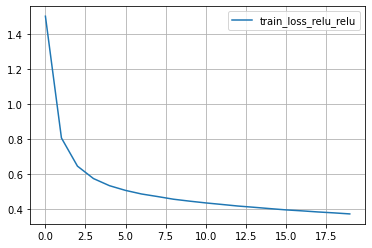

In [62]:
plt.plot(nn.loss_total,label='train_loss_relu_relu')
plt.legend(loc='best')
plt.grid()
plt.show()

### Relu(x2)+ELU 4 layers 

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(nn.target, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.94      0.95      1032
           3       0.94      0.94      0.94      1010
           4       0.95      0.93      0.94       982
           5       0.93      0.92      0.93       892
           6       0.94      0.96      0.95       958
           7       0.96      0.93      0.94      1028
           8       0.93      0.92      0.92       974
           9       0.90      0.94      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



### Relu(x2)+ELU 4 layers +Drop

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(nn.target, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.92      0.94      1032
           3       0.91      0.95      0.93      1010
           4       0.94      0.93      0.94       982
           5       0.94      0.91      0.92       892
           6       0.94      0.95      0.94       958
           7       0.95      0.93      0.94      1028
           8       0.93      0.92      0.92       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



### Relu(x2)+ELU 4 layers +Drop + Batch_norm

In [335]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(nn.target, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.37      0.79      0.50       980
           1       0.88      0.91      0.90      1135
           2       0.84      0.52      0.64      1032
           3       0.74      0.66      0.69      1010
           4       0.72      0.69      0.71       982
           5       0.44      0.13      0.20       892
           6       0.76      0.87      0.81       958
           7       0.69      0.68      0.69      1028
           8       0.36      0.39      0.37       974
           9       0.59      0.47      0.52      1009

    accuracy                           0.62     10000
   macro avg       0.64      0.61      0.60     10000
weighted avg       0.65      0.62      0.61     10000



In [418]:
## хз че так плохо с батч нормом либо на этих данных плохая затея либо не так реализовал

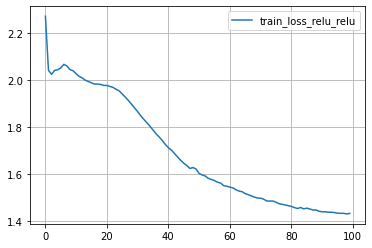

In [334]:
plt.plot(nn.loss_total,label='train_loss_relu_relu')
plt.legend(loc='best')
plt.grid()
plt.show()

### Relu(x2)+ELU 4 layers +Drop  + l2 reg

In [414]:
print(classification_report(y_test, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.96      0.97       892
           6       0.96      0.98      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



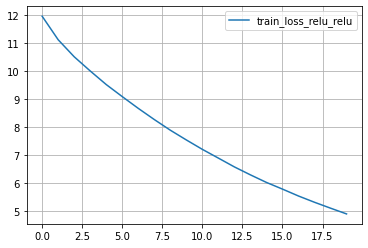

In [415]:
plt.plot(nn.loss_total,label='train_loss_relu_relu')
plt.legend(loc='best')
plt.grid()
plt.show()

In [417]:
confusion_matrix(y_test, predicted)

array([[ 962,    0,    1,    1,    0,    5,    6,    1,    2,    2],
       [   0, 1122,    2,    1,    0,    0,    4,    1,    5,    0],
       [   4,    2,  997,    4,    3,    0,    5,    9,    8,    0],
       [   0,    0,    3,  989,    0,    4,    0,    6,    6,    2],
       [   0,    0,    2,    0,  957,    0,    4,    2,    2,   15],
       [   4,    1,    0,   10,    1,  857,   10,    1,    5,    3],
       [   4,    3,    0,    0,    6,    6,  935,    0,    4,    0],
       [   1,    8,   11,    2,    0,    0,    0,  995,    1,   10],
       [   2,    0,    2,    6,    4,    3,    5,    2,  946,    4],
       [   4,    5,    0,    6,    6,    2,    1,    4,    3,  978]])